<h1> DSC 210 Numerical Linear Algebra - Final project </h1>

<h2><i>Object Tracking</h2>


*Ananay Gupta – A69033310* <br />
*Chirag Agarwal – A69034328* <br />
*Raghav Kachroo – A69035155* <br />
*Shankara Narayanan Venkateswara Raju – A69034474*

# Table of Contents

## 1. Kalman Filtering for Object Tracking
- ### 1.1 Auxiliary Functions
- ### 1.2 `predict` Function
- ### 1.3 `update` Function
- ### 1.4 `kalman_filter` Function
- ### 1.5 Applying Kalman Filter for Video Object Tracking

## 2. DeepSORT Algorithm for Object Tracking
- ### 2.1 Object Detection using YOLO
- ### 2.2 Object Tracking with DeepSort

## 3. Evaluation of the models 
- ### 3.1 Evaluation of the Kalman Filtering approach 
- ### 3.2 Evaluation of the DeepSORT approach
- ### 3.3 Real-time comparision of Kalman Filtering and DeepSORT approaches

### Installing the requirements

In [1]:
!pip install -r requirements.txt

In [2]:
import numpy as np
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort
from tqdm import tqdm

### 1.1 Auxiliary Functions

In [3]:
def load_annotations(annotation_file):
    with open(annotation_file, 'r') as file:
        annotations = [list(map(int, line.strip().split(','))) for line in file.readlines()]
    return annotations

In [4]:
def find_center(frame_idx, annotations):
    # Get the annotation for the current frame
    if frame_idx < len(annotations):
        x, y, w, h = annotations[frame_idx] 
        center = [x + w // 2, y + h // 2] 
        return center
    else:
        print("Warning: No annotation available for frame", frame_idx)
        return None 

### 1.2 `predict` Function

The `predict` function performs the prediction step in the Kalman filter algorithm. It estimates the next state of the system and updates the error covariance matrix based on the system model.

#### Inputs:
- `A`: State transition matrix, defining how the state evolves over time.
- `B`: Control input matrix, mapping control inputs to the state space.
- `x`: Current state vector.
- `u`: Control input vector (e.g., acceleration).
- `P`: Current error covariance matrix, representing uncertainty in the state estimate.
- `Q`: Process noise covariance matrix, accounting for model inaccuracies.

#### Outputs:
- Updated state vector (`x`).
- Updated error covariance matrix (`P`).

#### Key Steps:
1. **State Update**: 
   $x_k = A * x_(k-1) + B * u_(k-1)$
   Predicts the next state using the current state and control inputs.

2. **Error Covariance Update**: 
   $P_k = A \cdot P_{k-1} \cdot A^T + Q$
   Updates the uncertainty in the state estimate.

This step prepares the Kalman filter for the next measurement update.


In [5]:
def predict(A,B,x,u,P,Q):   
    # Update states           
    x = np.dot(A,x) + np.dot(B, u)  #x_k =Ax_(k-1) + Bu_(k-1)       
    # Calculate error covariance
    P = np.dot(np.dot(A,P), A.T) + Q  # P= A*P*A' + Q     
    return x

### 1.3 `update` Function

The `update` function performs the measurement update step in the Kalman filter algorithm. It adjusts the predicted state and error covariance using incoming sensor measurements to improve the accuracy of the state estimate.

#### Inputs:
- `H`: Measurement matrix, mapping the state space to the measurement space.
- `x`: Predicted state vector.
- `P`: Predicted error covariance matrix, representing uncertainty in the prediction.
- `R`: Measurement noise covariance matrix, accounting for uncertainty in the measurements.
- `z`: Measurement vector (e.g., observed position).

#### Outputs:
- Updated state vector (`x`).

#### Key Steps:
1. **Innovation Covariance**:  
   Computes the innovation covariance matrix (`S`) using:  
   `S = H * P * H^T + R`  
   This represents the uncertainty in the predicted measurements.

2. **Kalman Gain Calculation**:  
   Computes the Kalman gain (`K`) using:  
   `K = P * H^T * inv(S)`  
   The Kalman gain determines the weight given to the measurement versus the prediction.

3. **State Update**:  
   Adjusts the state estimate (`x`) using:  
   `x = x + K * (z - H * x)`  
   This incorporates the difference between the actual measurement (`z`) and the predicted measurement (`H * x`).

4. **Error Covariance Update**:  
   Updates the error covariance matrix (`P`) using:  
   `P = (I - K * H) * P`  
   This reduces the uncertainty in the state estimate based on the new measurement.

5. **State Formatting**:  
   After the update, the state vector `x` is reformatted to include zeros for velocities.

This function ensures that the Kalman filter refines its predictions based on actual observations, improving the reliability of the system.


In [6]:
def update(H,x,P,R, z):  
    S = np.dot(H, np.dot(P, H.T)) + R   # S = H*P*H'+R
    K = np.dot(np.dot(P, H.T), np.linalg.inv(S)) # K = P * H'* inv(H*P*H'+R)   
    x = np.round(x + np.dot(K,(z - np.dot(H, x))))  # Estimate x
    x=([x[0,0],x[1,1],0,0])    
    I = np.eye(H.shape[1])
    # Update error covariance matrix
    P = (I - (K * H)) * P     
    return x

### 1.4 `kalman_filter` Function

The `kalman_filter` function initializes all the necessary matrices and variables for implementing the Kalman filter algorithm. These include state transition matrices, control input matrices, noise covariances, and the initial state.

#### Outputs:
- `A`: State transition matrix, modeling how the state evolves over time.
- `B`: Control input matrix, mapping external inputs to the state.
- `H`: Measurement matrix, mapping the state to the observed measurements.
- `Q`: Process noise covariance matrix, accounting for inaccuracies in the model.
- `P`: Initial error covariance matrix, representing initial uncertainty in the state.
- `R`: Measurement noise covariance matrix, representing sensor measurement noise.
- `u`: Control input vector, describing external influences (e.g., acceleration).
- `x`: Initial state vector, representing the starting point of the system.

#### Key Components:
1. **Sampling Time (`dt`)**:  
   Set to `1`, representing a unit time step for the state update.

2. **Control Inputs (`u_x`, `u_y`)**:  
   Initial control inputs for the system, set to `1` for both x and y directions.

3. **State Transition Matrix (`A`)**:  
   Models how the state evolves between time steps, incorporating position and velocity:

4. **Control Input Matrix (`B`)**:  
Maps the control input vector to the state space:

5. **Measurement Matrix (`H`)**:  
Maps the state vector to the measurement space, assuming we observe only position:

6. **Process Noise Covariance (`Q`)**:  
Accounts for uncertainties in the system model, incorporating acceleration noise:

7. **Measurement Noise Covariance (`R`)**:  
Represents sensor noise, defined as:

8. **Initial Error Covariance (`P`)**:  
Initialized as an identity matrix, indicating equal uncertainty in all state variables.

9. **Initial State Vector (`x`)**:  
Starts at `[0, 0, 0, 0]`, representing the initial position and velocity in both x and y directions.

This function sets up all the parameters required to start the Kalman filter algorithm.


In [7]:
def kalman_filter():
    # Define sampling time
    dt = 1
    u_x = 1
    u_y = 1
    std_acc = 1
    x_std_meas=0.1
    y_std_meas=0.1
    # Define the  control input variables
    u = np.matrix([[u_x],[u_y]])
    # Intial State
    x = np.matrix([[0],[0],[0],[0]])

    # Define the State Transition Matrix A
    A = np.matrix([[1, 0, dt, 0],
                        [0, 1, 0, dt],
                        [0, 0, 1, 0],
                        [0, 0, 0, 1]])
    # Define the Control Input Matrix B
    B = np.matrix([[(dt**2)/2, 0],
                        [0, (dt**2)/2],
                        [dt,0],
                        [0,dt]])
    # Define Measurement Mapping Matrix
    H = np.matrix([[1, 0, 0, 0],
                        [0, 1, 0, 0]])
    #Initial Process Noise Covariance
    Q = np.matrix([[(dt**4)/4, 0, (dt**3)/2, 0],
                        [0, (dt**4)/4, 0, (dt**3)/2],
                        [(dt**3)/2, 0, dt**2, 0],
                        [0, (dt**3)/2, 0, dt**2]]) * std_acc**2
    #Initial Measurement Noise Covariance
    R = np.matrix([[x_std_meas**2,0],[0, y_std_meas**2]])
    #Initial Covariance Matrix
    P = np.eye(A.shape[1]) 
    return A, B, H, Q, P, R, u, x

### 1.5 `KL_object_tracking` Function

The `object_tracking` function tracks objects in a sequence of video frames using the Kalman filter and outputs a processed video and a CSV file with tracking data.

#### Key Steps:
1. **Initialize Kalman Filter**: Set up matrices for prediction and update steps.
2. **Process Frames**: For each frame:
   - Load annotations and compute object center.
   - Predict and update object position using the Kalman filter.
   - Overlay bounding boxes for ground truth, predictions, and updates.
3. **Save Results**:
   - Save the processed video with visual tracking.
   - Export tracking data (predicted vs. ground truth positions) to a CSV.

#### Outputs:
- A video with visualized tracking.
- A CSV file containing frame-wise tracking data.


In [8]:
def KL_object_tracking(frames, annotations, save_video_path):
    A, B, H, Q, P, R, u, x = kalman_filter()
    
    # Load the frames
    frames_folder = frames
    frame_files = sorted(os.listdir(frames_folder))
    if not frame_files:
        print("No frames found in the specified folder.")
        return

    # Read the first frame to get dimensions
    first_frame_path = os.path.join(frames_folder, frame_files[0])
    first_frame = cv2.imread(first_frame_path)
    height, width, layers = first_frame.shape

    # Initialize VideoWriter to save the output video
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4
    video_writer = cv2.VideoWriter(save_video_path, fourcc, 30.0, (width, height))

    # List to store the results
    results = []

    # Starting frame index
    f_ind = 0
    while True:
        if f_ind < len(frame_files):
            frame_path = os.path.join(frames_folder, frame_files[f_ind])
            frame = cv2.imread(frame_path)
        else:
            break  # Exit loop when no more frames

        # Load the annotations
        annotation_file = annotations
        annots = load_annotations(annotation_file)
        center = find_center(f_ind, annots)
        if center is None:
            f_ind += 1
            continue  # Skip processing if no annotation is available

        dev = np.random.randint(-20, 30)  # Large error in observation is added
        z = [center[0] + dev, center[1] - dev]
        cv2.circle(frame, center, 10, (0, 255, 255), 2)

        # Predict
        x = predict(A, B, x, u, P, Q)
        (x1, y1) = (x[0], x[1])
        # Draw a rectangle as the predicted object position
        cv2.rectangle(frame, (int(x1 - 5), int(y1 - 5)), (int(x1 + 5), int(y1 + 5)), (0, 0, 255), 2)

        # Update
        x = update(H, x, P, R, z)
        (x2, y2) = (x[0], x[1])
        cv2.rectangle(frame, (int(x2 - 5), int(y2 - 5)), (int(x2 + 5), int(y2 + 5)), (255, 0, 255), 2)

        # Draw the bounding boxes
        x, y, w, h = map(int, annots[f_ind])
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

        x1, y1 = np.array(x1), np.array(y1)

        # Store the data in the results list
        results.append({
            "Frame_Index": f_ind,
            "Predicted_X": x1[0][0],
            "Predicted_Y": y1[0][0],
            "GroundTruth_X": center[0],
            "GroundTruth_Y": center[1]
        })

        # Update the state vector
        x = np.matrix([[x2], [y2], [0], [0]])

        # Write the frame to the video
        video_writer.write(frame)

        f_ind += 1

    # Convert the list of results to a DataFrame
    df = pd.DataFrame(results)

    # Release the video writer
    video_writer.release()
    print(f"Video saved to {save_video_path}")
    
    return df

## 2. DeepSORT Algorithm for Object Tracking


### 2.1 Object Detection using YOLO

In this section, we will implement object detection using the YOLO (You Only Look Once) model. YOLO is a state-of-the-art, real-time object detection system that is known for its speed and accuracy. We will use the YOLOv8 model for detecting objects in video frames.

### Steps Involved:

1. **Load YOLO Model**:
    - We will load the pre-trained YOLOv8 model using the provided weights file.

2. **Detect Objects**:
    - For each frame in the video, we will use the YOLO model to detect objects of a specific target class (e.g., 'car').


In [9]:
# Initialize YOLOv8 model
def load_yolo_model(yolo_weights):
    model = YOLO(yolo_weights)  
    return model

In [10]:
def detect_objects_yolo(model, frame, target_class):
    """
    Detect the object of a specific target class with the highest confidence in the frame using YOLO.

    Args:
        model: The YOLO model instance.
        frame: The input frame/image.
        target_class: The name of the class to detect

    Returns:
        A single detection in the format ([x, y, w, h], confidence, class) or None if no detection is found.
    """
    results = model(frame, verbose=False)
    highest_conf_detection = None  # To store the detection with the highest confidence

    for result in results:
        for box in result.boxes:
            conf = float(box.conf[0])  # Confidence score
            cls = int(box.cls[0])  # Class ID
            if model.names[cls] == target_class:
                x1, y1, x2, y2 = map(int, box.xyxy[0])  # Bounding box coordinates
                w, h = x2 - x1, y2 - y1  # Convert to width and height
                detection = [([x1, y1, w, h], conf, cls)]

                # Update if this detection has higher confidence
                if highest_conf_detection is None or conf > highest_conf_detection[0][1]:
                    highest_conf_detection = detection

    return highest_conf_detection

### 2.2 Object Tracking with DeepSort

In this section, we will implement object tracking using the DeepSort algorithm. DeepSort is an extension of the Simple Online and Realtime Tracking (SORT) algorithm, which integrates deep learning for appearance feature extraction. This allows for more robust and accurate tracking, especially in scenarios with occlusions and similar-looking objects.

### Steps Involved:

1. **Initialize DeepSort Tracker**:
    - We will initialize the DeepSort tracker with default parameters.

2. **Read Ground Truth Data**:
    - We will read the ground truth data from a file to compare the tracking results with the actual object positions.

3. **Process Video Frames**:
    - For each frame in the video, we will:
        - Detect objects using the YOLO model.
        - Update the DeepSort tracker with the detected objects.
        - Draw bounding boxes for both the predicted and ground truth positions.
        - Save the results to a CSV file and generate an output video with the tracking results.

### Functions:

- `init_deepsort()`: Initializes the DeepSort tracker.
- `read_ground_truth(gt_file)`: Reads the ground truth file and returns a list of bounding box centers.
- `process_video_with_tracking(frames_dir, output_video, yolo_model, tracker, ground_truth_file, output_csv, fps=30)`: Processes video frames with YOLO detection and DeepSort tracking, and saves the results.

By following these steps, we can achieve accurate and efficient object tracking in video sequences using the combination of YOLO for object detection and DeepSort for tracking.

In [11]:
def init_deepsort():
    """ Initialize DeepSORT tracker with default parameters."""
    tracker = DeepSort(max_age=30, n_init=3, nn_budget=None)
    return tracker

In [12]:
def read_ground_truth(gt_file):
    """Read ground truth file and return list of bounding box centers."""
    ground_truth = []
    with open(gt_file, 'r') as file:
        for line in file:
            x, y, w, h = map(float, line.strip().split(','))
            x_center = x + w / 2
            y_center = y + h / 2
            ground_truth.append((x_center, y_center,w,h))
    return ground_truth

In [13]:
def process_video_with_tracking(frames_dir, output_video, yolo_model, tracker, ground_truth_file, target_class , fps=30):
    """ Process video frames with YOLO detection and DeepSORT tracking.

    Args:
        frames_dir (str): Path to the directory containing video frames.
        output_video (str): Path to save the output video.
        yolo_model : YOLO model instance.
        tracker : DeepSORT tracker instance.
        ground_truth_file (str): Path to the ground truth file.
        target_class (str): The target class to detect.
        fps (int, optional): Frames per second for the output video (default: 30).
    """
    # Read ground truth data
    ground_truth = read_ground_truth(ground_truth_file)

    # Prepare DataFrame to store results
    results = []

    # Get all frame paths
    frames = sorted([os.path.join(frames_dir, f) for f in os.listdir(frames_dir) if f.endswith('.jpg')])
    first_frame = cv2.imread(frames[0])
    height, width, _ = first_frame.shape

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video, fourcc, fps, (width, height))

    for i, frame_path in enumerate(tqdm(frames, desc="Processing frames", unit="frame")):
        # print(f"Processing frame {i + 1}/{len(frames)}: {frame_path}")  # Debugging

        frame = cv2.imread(frame_path)
        if frame is None:
            print(f"Error: Frame {frame_path} could not be loaded. Skipping.")
            continue

        # YOLO detection
        detections = detect_objects_yolo(yolo_model, frame, target_class)
        # print(f"Frame {i + 1} detections: {detections}")  # Debugging YOLO output

        # Update DeepSORT tracker
        tracks = tracker.update_tracks(detections or [], frame=frame)

        # Extract the first predicted tracker for simplicity
        predicted_x, predicted_y = None, None
        predicted_bbox = None  # Store the bounding box for the first predicted tracker

        for track in tracks:
            if not track.is_confirmed() or track.time_since_update > 1:
                continue
            l, t, r, b = map(int, track.to_tlbr())
            predicted_x = (l + r) / 2
            predicted_y = (t + b) / 2
            predicted_bbox = (l, t, r, b)
            break  # Use only the first confirmed tracker

        # Get ground truth values for this frame
        gt_x, gt_y,gt_w,gt_h = ground_truth[i] if i < len(ground_truth) else (None, None,None,None)

        # Draw bounding box for predicted tracker (in red)
        if predicted_bbox:
            l, t, r, b = predicted_bbox
            cv2.rectangle(frame, (l, t), (r, b), (0, 0, 255), 2)  # Red bounding box

        # Draw ground truth bounding box (in green)
        if gt_x is not None and gt_y is not None:
            gt_l = int(gt_x - gt_w / 2)
            gt_t = int(gt_y - gt_h / 2)
            gt_r = int(gt_x + gt_w / 2)
            gt_b = int(gt_y + gt_h / 2)
            cv2.rectangle(frame, (gt_l, gt_t), (gt_r, gt_b), (0, 255, 0), 2)  # Green bounding box

        # Append to results
        results.append({
            "Frame_Index": i,
            "Predicted_X": predicted_x,
            "Predicted_Y": predicted_y,
            "GroundTruth_X": gt_x,
            "GroundTruth_Y": gt_y
        })

        # Write the frame to the video
        out.write(frame)

    # Save results in a df
    df = pd.DataFrame(results)

    out.release()
    print(f"Video saved at {output_video}")
    return df

## 3. Evaluation of the models



### `signed_euclidean_distance` Function
This function calculates the signed Euclidean distance between two points, factoring in their direction relative to a reference vector.

#### Key Steps:
1. **Compute Directional Vector**: Subtract point `p1` from `p2`.
2. **Calculate Magnitude**: Compute the Euclidean distance using the magnitude of the vector difference.
3. **Determine Sign**: Use the dot product with a reference vector to determine the sign of the distance.

#### Output:
- The signed Euclidean distance between `p1` and `p2`.

In [14]:
def signed_euclidean_distance(p1, p2, reference_vector=np.array([1, 0])):
    p1, p2 = np.array(p1), np.array(p2)
    vector_diff = p2 - p1  # Directional vector
    euclidean_distance = np.linalg.norm(vector_diff)  # Magnitude of distance

    # Determine the sign using the dot product with the reference vector
    sign = np.sign(np.dot(vector_diff, reference_vector))
    return sign * euclidean_distance

### `plot_center_error` Function
This function visualizes the error in predicted object positions versus ground truth over frames.

#### Key Steps:
1. **Extract Data**: Gather predicted and ground truth positions from the dataframe.
2. **Compute Distances**: Calculate signed and unsigned Euclidean distances between predicted and ground truth positions.
3. **Plot Error**: 
   - Display signed distances with positive and negative regions shaded.
   - Plot the signed distance over frames, including a zero reference line.
4. **Summarize Error**: Print the sum of unsigned distances for evaluation.

#### Output:
- Two line plots (original and zoomed) of signed distances, highlighting positive and negative errors.
- Sum of unsigned distances in the total video denoting the net error in tracker placement 

In [15]:
def plot_center_error(df):
    predicted, ground = [], []
    df.dropna(inplace=True)
    for ind, row in df.iterrows():
        predicted.append((row['Predicted_X'], row['Predicted_Y']))
        ground.append((row['GroundTruth_X'], row['GroundTruth_Y']))
    # finding the distance between the predicted and ground truth 
    signed_distances, unsigned_distances = [], []
    for i, j in zip(predicted, ground):
        signed_distances.append(signed_euclidean_distance(np.array(j), np.array(i)))
        unsigned_distances.append(euclidean(i, j))
    
    frames = np.arange(100, 150)  
    signed_distances = np.array(signed_distances)
    # Plot the line plot
    plt.figure(figsize=(8, 5))
    plt.plot(frames, signed_distances[100:150], label='Signed Distances', color='blue')

    plt.fill_between(
        frames, signed_distances[100:150], 0, where=(signed_distances[100:150] > 0), 
        interpolate=True, color='green', alpha=0.3, label='Positive'
    )
    plt.fill_between(
        frames, signed_distances[100:150], 0, where=(signed_distances[100:150] < 0), 
        interpolate=True, color='red', alpha=0.3, label='Negative'
    )

    # Add a dotted horizontal line at y=0
    plt.axhline(0, color='red', linestyle='--', label='Zero Line')

    # Add labels and title
    plt.xlabel('Frames')
    plt.ylabel('Signed Distance')
    plt.title('Center Error visualizer (zoomed)')

    plt.legend()
    plt.grid(True) 
    plt.show()


    frames = np.arange(len(signed_distances))  # x-axis values (indices)

    # Plot the line plot
    plt.figure(figsize=(8, 5))
    plt.plot(frames, signed_distances, label='Signed Distances', color='blue')

    # Add a dotted horizontal line at y=0
    plt.axhline(0, color='red', linestyle='--', label='Zero Line')

    # Add labels and title
    plt.xlabel('Frames')
    plt.ylabel('Signed Distance')
    plt.title('Center Error visualizer')

    # Add a legend
    plt.legend()

    # Show the plot
    plt.grid(True)  # Optional: Add a grid
    plt.show()
    
    print(f"The sum of unsigned distances is {sum(unsigned_distances)}")



#### Update Dataset Path

Please change the path of the dataset you want to use in the code below. The output video will be saved in the `output-vids/Kalman-Tracking` and `output-vids/DeepSort-Tracking` folder.

```python
# Frame directory and output paths
frames = "path/to/your/dataset/frames"
annotations = "path/to/your/dataset/groundtruth.txt"
save_video_path = "output-vid/DeepSort-Tracking/tracking_results.mp4"
```


In [16]:
def extract_segment(path, segment_index=-2):
    """
    Extracts a specific segment from a given path.

    Args:
        path (str): The file path to process.
        segment_index (int): The index of the segment to extract, default is -2 (second last).

    Returns:
        str: The extracted segment.
    """
    # Normalize the path and split into segments
    segments = os.path.normpath(path).split(os.sep)
    
    # Extract the desired segment
    if -len(segments) <= segment_index < len(segments):
        return segments[segment_index]
    else:
        raise IndexError("Segment index out of range.")


In [17]:
def ensure_directory_exists(path):
    """
    Ensures that the directory for the given path exists. If it doesn't, creates it.

    Args:
        path (str): The directory path to check or create.
    """
    if not os.path.exists(path):
        os.makedirs(path)

In [18]:
if __name__ == '__main__':
    
    yolo_weights = "best_model_weights/best.pt" 

    # Load YOLO model
    yolo_model = load_yolo_model(yolo_weights)


    # Initialize DeepSORT tracker
    tracker = init_deepsort()
    
    frames = "Datasets/car/car-4/img" 
    annotations = "Datasets/car/car-4/groundtruth.txt"
    
    file_name = extract_segment(frames, -2)
    class_name = extract_segment(frames, -3)
    
    save_video_path_kalman = "output_vids/Kalman-Tracking/"
    save_video_path_DeeepSort = "output_vids/DeepSort-Tracking/"
    
    ensure_directory_exists(save_video_path_kalman)
    ensure_directory_exists(save_video_path_DeeepSort)
    
    save_video_path_kalman = os.path.join(save_video_path_kalman, f"{file_name}-kalman.mp4")
    save_video_path_DeeepSort = os.path.join(save_video_path_DeeepSort, f"{file_name}-deepsort.mp4")
    
    kalman_filter_results_df = KL_object_tracking(frames, annotations, save_video_path_kalman)
    deepsort_eval_df = process_video_with_tracking(frames, save_video_path_DeeepSort, yolo_model, tracker, annotations, class_name)
    

C:\Users\SANKARAN\AppData\Local\Temp\ipykernel_17488\3443371925.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cv2.rectangle(frame, (int(x1 - 5), int(y1 - 5)), (int(x1 + 5), int(y1 + 5)), (0, 0, 255), 2)


Video saved to output_vids/Kalman-Tracking/car-4-kalman.mp4


Processing frames: 100%|██████████| 1531/1531 [03:55<00:00,  6.51frame/s]

Video saved at output_vids/DeepSort-Tracking/car-4-deepsort.mp4


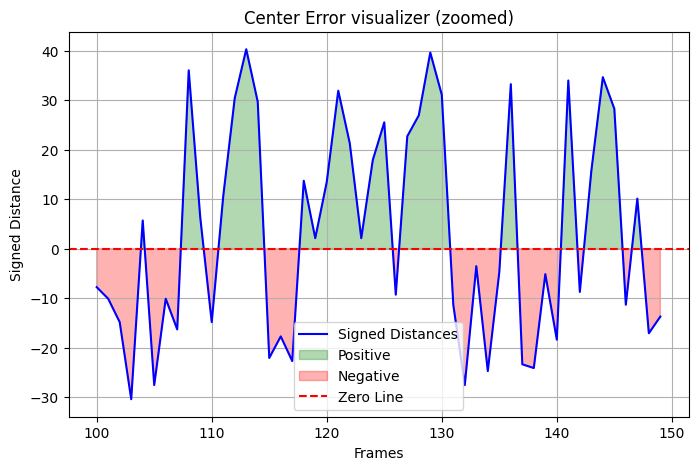

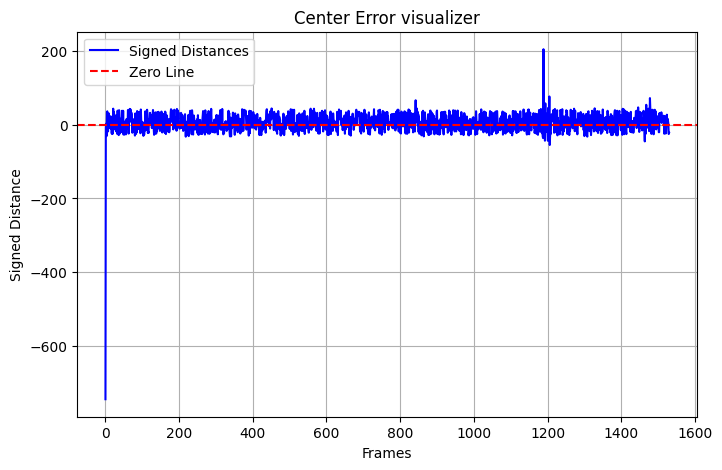

The sum of unsigned distances is 29380.245072030317


In [19]:
plot_center_error(kalman_filter_results_df)

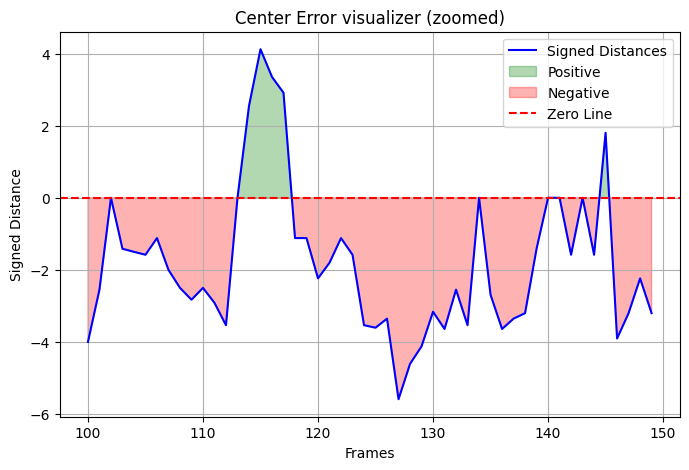

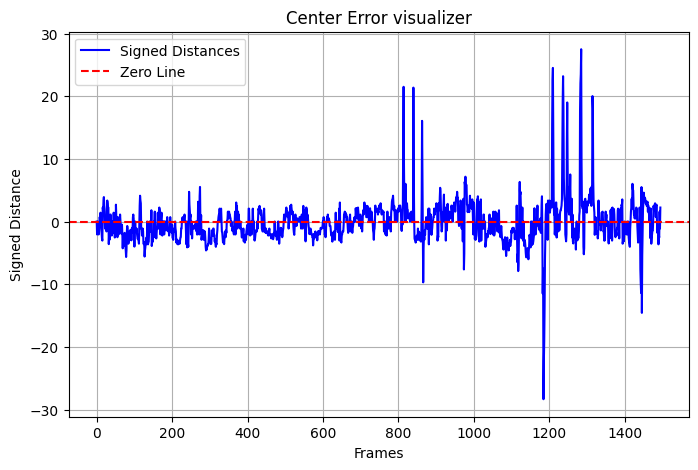

The sum of unsigned distances is 3534.0850571014603


In [20]:
plot_center_error(deepsort_eval_df)